<a href="https://colab.research.google.com/github/luigiselmi/finstat/blob/main/hilpisch/ch13_bayesian_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ch.13 Bayesian statistics
The goal of a statistical analysis of a process is to figure out what are the variables that play a role and the relationships between them. Usually the observations have a random component. We might have a model of the process, for example we might start with two variables: one dependent variable y and one independent variable x. We might make two additional assumptions: the relationship between y and x is linear and the random compnent is normally distributed. The next step is to assess our assumptions using a sample of observations.

In [1]:
import math
import numpy as np
import scipy.stats as scs
import scipy.optimize as sco
from scipy import interpolate
import pymc as pm
import statsmodels.api as sm
import pandas as pd
from pylab import plt, mpl
import warnings
warnings.filterwarnings('ignore')
print('Matplotlib version: {}'.format(mpl.__version__))
print('NumPy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('PyMC version: {}'.format(pm.__version__))
print('Statsmodels version: {}'.format(sm.__version__))

Matplotlib version: 3.10.0
NumPy version: 2.0.2
Pandas version: 2.2.2
PyMC version: 5.26.1
Statsmodels version: 0.14.5


We can simulate a linear process by sampling the random component from a standard distribution with mean=0 and standard deviation std=1

$$y = a + bx + \epsilon$$

In [2]:
size = 500
x = np.linspace(0, 10, size)
y = 4 + 2 * x + np.random.standard_normal(size) * 2

Text(0, 0.5, 'y')

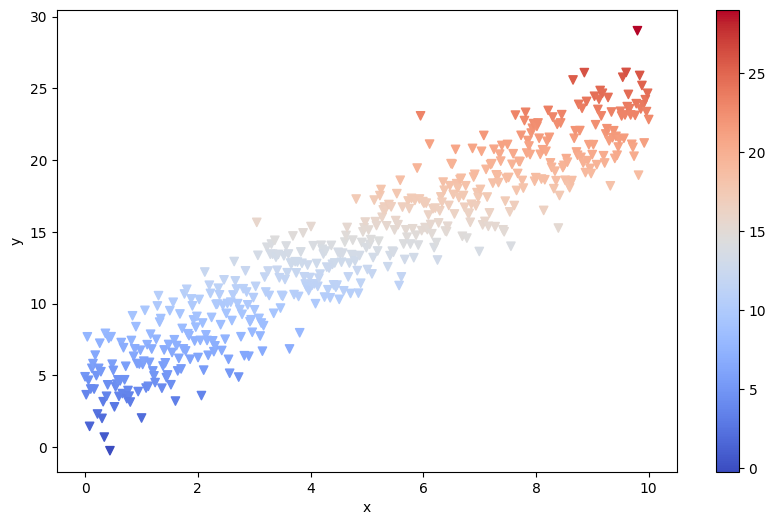

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

## Ordinary least squares
Now we can fit the simulated data using the [NumPy Polynomial.fit()](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.fit.html) method that performs a polynomial fit using the least squares method. Since we assume the relationship is linear we set the degree of the polynomial to 1. The method returns the coefficients of the polynomial.

In [4]:
from numpy.polynomial import Polynomial
reg = Polynomial.fit(x, y, deg=1)
reg

Polynomial([14.03191117,  9.7950611 ], domain=[ 0., 10.], window=[-1.,  1.], symbol='x')

In [5]:
a = reg.convert().coef[0]
b = reg.convert().coef[1]
print('Linear coefficients\na={:.2f}\nb={:.2f}'.format(a, b))

Linear coefficients
a=4.24
b=1.96


We plot the linear fit to the data

Text(0, 0.5, 'y')

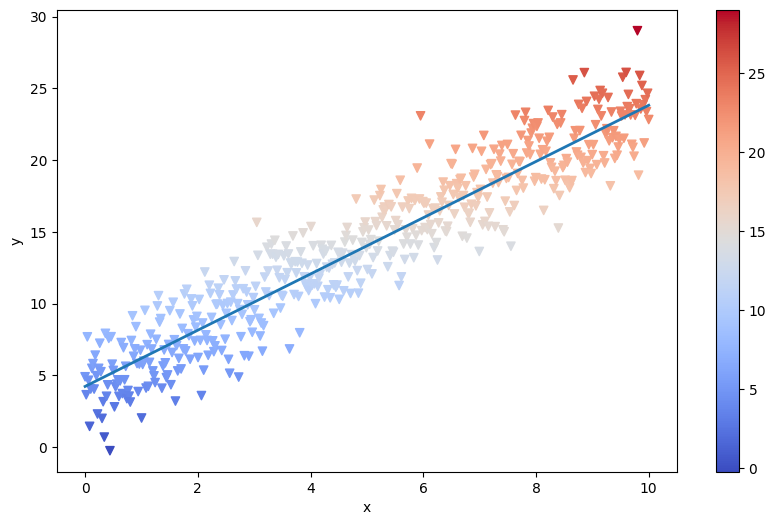

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
y_fit = a + b * x
plt.plot(x, y_fit, lw=2.0)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

## Bayes theorem
The coefficient a and b are not fixed values, they come with an associated error that can be estimated with a certain degree of confidence or accuracy. We can use the Bayesian approach to calculate the standard error of the two coefficients. Before that we discuss briefly the theory behind the Bayes theorem. Bayes' theorem is based on the multiplication theorem that can be stated as

$$P(H|D)P(D) = P(D|H)P(D)$$

so that

$$P(H|D) = \frac{P(D|H)P(H)}{P(D)}$$

where the probabilities have the following interpretation

* The hypothesis, or prior probability, P(H)
* The likelihood, or probability for the observations given the initial hypothesis, P(D|H)
* The posterivion probability, given the observations, P(H|D)
* The total probability of the observations, P(D)

In our example we assume the hypothesis that the coefficients a and b are normally distributed and independent with zero mean value and variance in [0, 20.0] and [0, 10.0] respectively, that is our prior is

$$P(H) = P(a,b) = P(a)P(b) = N(0, \sigma_a)N(0, \sigma_b)$$

For the likelihood we assume that the y(x) values are also normally distributed with mean value $\overline{y}$, calculated from the observations, and a variance $\sigma$ that we assume uniformly distributed in [0, 10.0]

$$P(D|H) = N(\overline{y}, \sigma) = \frac{1}{\sigma \sqrt{2 \pi}}e^{\frac{1}{2}(\frac{y - \overline{y}}{\sigma})^2}$$

and

$$\sigma = U(0, 10.0)$$

We use [PyMC](https://www.pymc.io/) to build the model.

In [7]:
%%time
with pm.Model() as model:
  # model
  a = pm.Normal('a', mu=0, sigma=20)
  b = pm.Normal('b', mu=0, sigma=10)
  sigma = pm.Uniform('sigma', lower=0, upper=10)
  y_est = a + b * x
  likelihood = pm.Normal('y', mu=y_est, sigma=sigma, observed=y)
  # inference
  start = pm.find_MAP()
  step = pm.NUTS()
  trace = pm.sample(100, tune=1000, start=start, progressbar=True)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


CPU times: user 5.01 s, sys: 365 ms, total: 5.38 s
Wall time: 6.49 s


In [8]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,4.281,0.179,3.962,4.593,0.015,0.009,138.0,134.0,1.00
b,1.953,0.031,1.893,2.005,0.003,0.002,143.0,179.0,1.01
sigma,2.015,0.063,1.904,2.140,0.006,0.004,111.0,87.0,1.02


The sampler generates a number of parallel chains with the results for the parameters depending on the number of cores available. The values in the chains can be used together by flattening the array in one single dimension.

In [10]:
trace['posterior']

<xarray.Dataset> Size: 6kB
Dimensions:  (chain: 2, draw: 100)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
Data variables:
    a        (chain, draw) float64 2kB 4.419 4.343 4.349 ... 4.461 4.017 4.093
    b        (chain, draw) float64 2kB 1.926 1.938 1.952 ... 1.927 1.984 1.994
    sigma    (chain, draw) float64 2kB 2.14 2.157 2.146 ... 2.027 1.986 1.928
Attributes:
    created_at:                 2025-11-25T17:49:22.380111+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1
    sampling_time:              1.5877454280853271
    tuning_steps:               1000

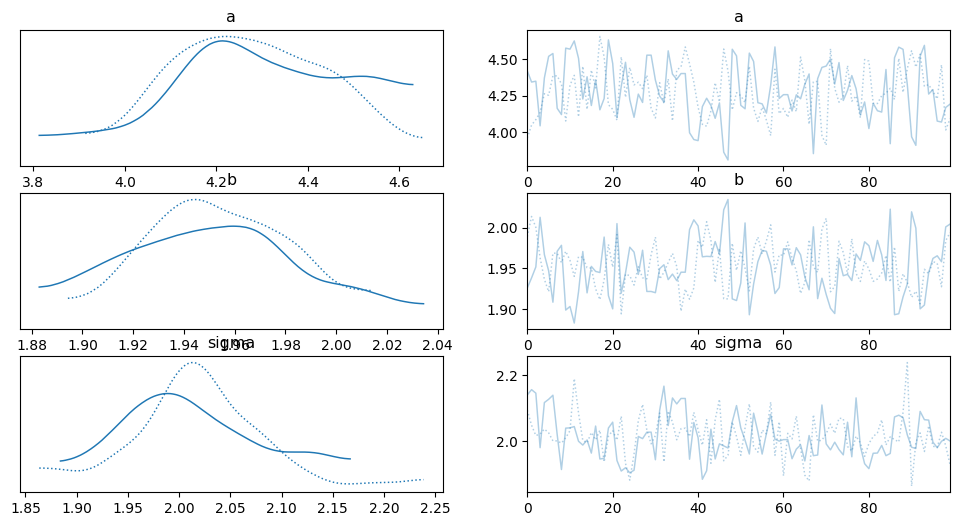

In [11]:
pm.plot_trace(trace, lines={'alpha': 4, 'beta': 2, 'sigma': 2});

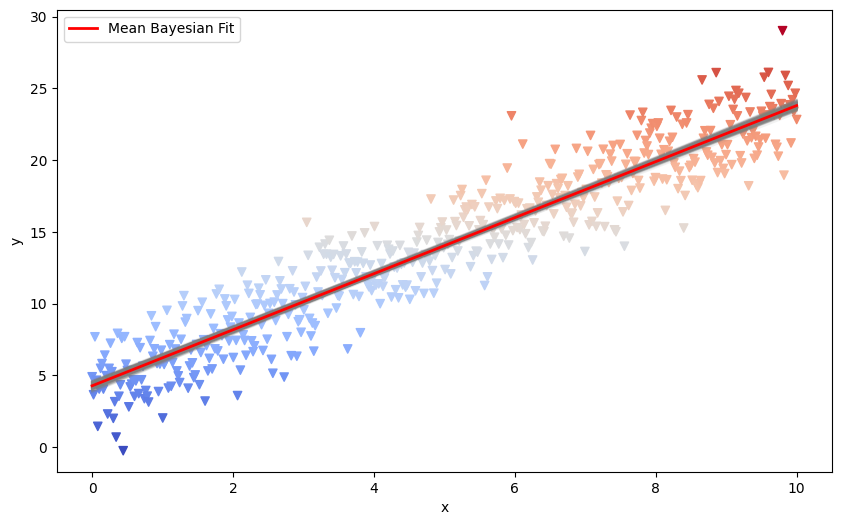

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
#plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

# Access the posterior samples for 'a' and 'b' and flatten them
a_samples = trace.posterior.a.values.flatten()
b_samples = trace.posterior.b.values.flatten()

# Iterate through each sample and plot the corresponding line
for i in range(len(a_samples)):
  y_sampled = a_samples[i] + b_samples[i] * x
  plt.plot(x, y_sampled, color='gray', alpha=0.1) # Plot with some transparency

# Optionally, plot the mean Bayesian fit
mean_a = a_samples.mean()
mean_b = b_samples.mean()
y_mean_fit = mean_a + mean_b * x
plt.plot(x, y_mean_fit, color='red', lw=2.0, label='Mean Bayesian Fit')
plt.legend()